In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline, Pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import TransformedTargetRegressor

from tqdm import tqdm 

import target_predicting_RF_function_and_feature_ranking_TNGSIM_0D as functions
import RF_target_predicting_and_learning_curves_functions_TNGSIM_0D as tp_lc_functions

In [2]:
# Using the 0D TNG100 SIM data at z=0 (version 6 of the dataset that includes Mvir in this notebook, 
# for further explanation see Notebook v3 updated and v14)

df_0D = pd.read_csv('TNG-SIM_images/v3_initial_analysis/v6_TNG-SIM_0D_Dataset_wMvir.csv')
df_raw = pd.read_csv('TNG-SIM_images/v3_initial_analysis/v4_TNG-SIM_Raw_Dataset.csv')
print("df_0D.shape", df_0D.shape)
print("df_raw.shape", df_raw.shape)

df_0D.shape (21598, 17)
df_raw.shape (21598, 19)


### <font color='purple'> <a id =10> </a> <br> Take Log10 of all features and target, both 0D & raw

In [3]:
def log_df(df_init):
    
    df = df_init.copy()
    for feature in df.columns.to_list():
        if 'log' not in feature:
            df.loc[:, feature + '_log']=df.loc[:,feature].apply(lambda x: np.log10(x + 1.e-8))
            df.drop(columns = [feature], inplace = True)
#             print(df.loc[:, feature])
        else:continue
        
    return df

In [4]:
df_raw_log = log_df(df_raw)

In [5]:
df_raw_log.shape

(21598, 19)

In [6]:
df_raw.shape

(21598, 19)

In [7]:
df_0D_log = log_df(df_0D)

In [8]:
df_0D_log.shape

(21598, 17)

In [9]:
df_0D.shape

(21598, 17)

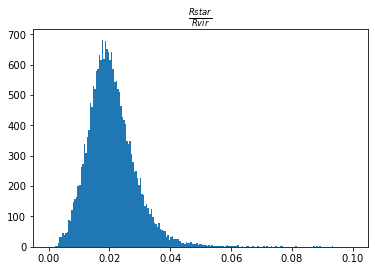

In [10]:
plt.hist(df_0D.SubhaloRstar_hs, bins=200, range=(0.0, 0.1))
plt.title(r'$\frac{Rstar}{Rvir}$')
plt.show()

#### Note about target (Rstar/Rvir) transformation:
When running SVR on SAMs R50/Rvir used to have too small values, so small that they overlapped with SVR tolerance limit. This is why we considered taking the log of the target to run the SVR. Another option that Ari used to overcome this problem is apply TransformedTargetRegressor() on the target. 

Ari says: It runs StandardScaler() on the target. Otherwise it is only being run on the features. Not sure how much difference it make (your fits are good), but from my reading of the SVR docs I thought it should be used. What is nice about the TransformedTargetRegressor() is that it still uses the score on the untransformed target for optimization. So the returned R2 is not on the scaled data. I think I used this mostly so that we didn't need to scale the target not to have small values, because originally that was our problem with SVR and the default tolerance value. I thought this was an easier explanation then we multiplied the size by 1000 or inverted the target, both of which have the problem of optimizing on a different target. I think log (r50/rvir) still had small values that caused SVR to fail sometimes, for the SAM.

This doesn't seem to be the case for SIMs (values Rstar/Rvir are not too small, se the histogram in the previous line), so maybe I don't have to normalize target. I will run SVR without normalizing the target, and then normalizing the target. Then I can compare how much better the model may become with a normalized target.

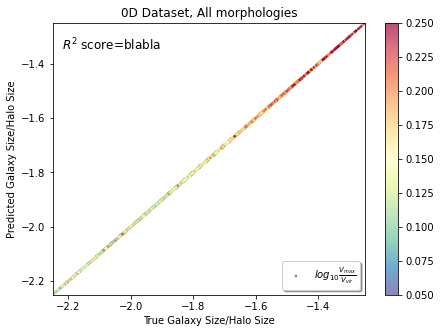

In [11]:
# Plot of 0D log10 Rstar vs 0D log10 Rstar to see the scale needed for the plot

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_0D_log.SubhaloRstar_hs_log, df_0D_log.SubhaloRstar_hs_log,
            c = df_0D_log.SubhaloVmax_hs_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}\frac{V_{max}}{V_{vir}}$', vmin=0.05, vmax=0.25)
ax.text(-2.22, -1.35, r'$R^{2}$ score=blabla', size=12)
ax.axis([-2.25,-1.25, -2.25,-1.25])
# ax.plot([-3.0, -1.0], [-3.0, -1.0], color = 'black', linewidth = 2)
ax.set_title(r'0D Dataset, All morphologies')
ax.set_xlabel('True Galaxy Size/Halo Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size/Halo Size')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v15_RF_FeatRank_Raw/Rstar_vs_Rstar.jpeg', dpi=500)
plt.show()

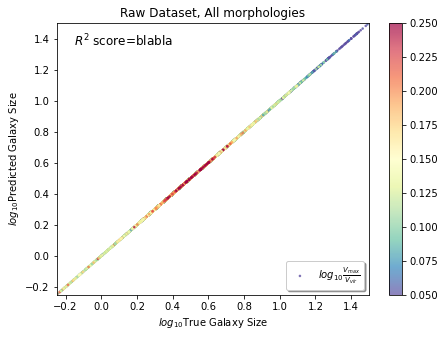

In [12]:
# Plot of log10 Raw Rstar vs log10 Raw Rstar to see the scale needed for the plot

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw_log.SubhaloRstar_log, df_raw_log.SubhaloRstar_log,
            c = df_0D_log.SubhaloVmax_hs_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}\frac{V_{max}}{V_{vir}}$', vmin=0.05, vmax=0.25)
ax.text(-0.15, 1.35, r'$R^{2}$ score=blabla', size=12)
ax.axis([-0.25,1.5, -0.25,1.5])
# ax.plot([-1.0, 2.0], [-1.0, 2.0], color = 'black', linewidth = 2)
ax.set_title(r'Raw Dataset, All morphologies')
ax.set_xlabel(r'$log_{10}$True Galaxy Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel(r'$log_{10}$Predicted Galaxy Size')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v15_RF_FeatRank_Raw/Rstar_vs_Rstar.jpeg', dpi=500)
plt.show()

### <font color='purple'> <a id =10> </a> <br> Complete 0D Dataset + Mvir: SVR

In [13]:
X_all = df_0D_log.drop(columns=['SubhaloRstar_hs_log'])
 

y_all = df_0D_log.loc[:,'SubhaloRstar_hs_log']

In [17]:
hyper_params = {'kernel':'rbf','C':100, 'gamma':0.1,'epsilon':0.1}
pipeline = Pipeline(steps=[('normalize', StandardScaler()), ('model',     SVR(**hyper_params))])
regr = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

In [18]:
regr

TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      StandardScaler()),
                                                     ('model',
                                                      SVR(C=100, gamma=0.1))]),
                           transformer=StandardScaler())

In [19]:
regr.fit(X_all, y_all)

TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      StandardScaler()),
                                                     ('model',
                                                      SVR(C=100, gamma=0.1))]),
                           transformer=StandardScaler())

In [20]:
regr.score(X_all, y_all)

0.9350002022942631

In [19]:
start_time = time.time()
# parameters = {'svr__kernel':['rbf'], \
#               'svr__gamma':['scale', 0.01, 1.0, 10, 100], 
#               'svr__C':[0.1, 1.0, 10.0, 100.0, 1000], \
#               'svr__epsilon':[0.05,0.1,0.2],
#               }
hyper_params = {'kernel':'rbf','C':[0.1, 1.0, 10.0, 100.0, 1000], 'gamma':['scale', 0.01, 1.0, 10, 100],
                'epsilon':[0.05,0.1,0.2]}
pipeline = Pipeline(steps=[('normalize', StandardScaler()), ('model', SVR(**hyper_params))])
regr_SV = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler()) 
model_all = GridSearchCV(hyper_params, estimator = regr_SV, cv = KFold(n_splits=3, shuffle=True), 
                     verbose = 3, n_jobs = -1, return_train_score=True)
model_all.fit(X_all, y_all)
print('Best params, best score:', "{:.4f}".format(model_all.best_score_), \
      model_all.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR results on TNG-SIM 0D Complete Dataset w Mvir & TransTargetReg: {elapsed_time:.3f} seconds")

TypeError: 'TransformedTargetRegressor' object is not iterable

In [25]:
# this code takes ~ ...min to run it on the complete TNG-SIM dataset with ~22,000 galaxies 

start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the regressor
print(piped_model.get_params())
#optimizing SVR

parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale', 0.01, 1.0, 10, 100], 
              'svr__C':[0.1, 1.0, 10.0, 100.0, 1000], \
              'svr__epsilon':[0.05,0.1,0.2],
              }


model_all = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 3, n_jobs = -1, return_train_score=True)

model_all.fit(X_all, y_all)

print('Best params, best score:', "{:.4f}".format(model_all.best_score_), \
      model_all.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR results on TNG-SIM 0D Complete Dataset w Mvir: {elapsed_time:.3f} seconds")

{'memory': None, 'steps': [('standardscaler', StandardScaler()), ('svr', SVR())], 'verbose': False, 'standardscaler': StandardScaler(), 'svr': SVR(), 'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'svr__C': 1.0, 'svr__cache_size': 200, 'svr__coef0': 0.0, 'svr__degree': 3, 'svr__epsilon': 0.1, 'svr__gamma': 'scale', 'svr__kernel': 'rbf', 'svr__max_iter': -1, 'svr__shrinking': True, 'svr__tol': 0.001, 'svr__verbose': False}
Fitting 3 folds for each of 75 candidates, totalling 225 fits
[CV 1/3] END svr__C=0.1, svr__epsilon=0.05, svr__gamma=1.0, svr__kernel=rbf;, score=(train=0.819, test=0.643) total time=   6.8s
[CV 3/3] END svr__C=0.1, svr__epsilon=0.05, svr__gamma=100, svr__kernel=rbf;, score=(train=0.563, test=-0.004) total time=  14.5s
[CV 1/3] END svr__C=0.1, svr__epsilon=0.2, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.721, test=0.715) total time=   0.5s
[CV 3/3] END svr__C=0.1, svr__epsilon=0.2, svr__gamma=scale, svr__kerne

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/3] END svr__C=0.1, svr__epsilon=0.05, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.838, test=0.827) total time=   4.9s
[CV 1/3] END svr__C=0.1, svr__epsilon=0.05, svr__gamma=10, svr__kernel=rbf;, score=(train=0.580, test=0.029) total time=  13.7s
[CV 2/3] END svr__C=0.1, svr__epsilon=0.1, svr__gamma=10, svr__kernel=rbf;, score=(train=0.489, test=0.024) total time=   9.2s
[CV 1/3] END svr__C=0.1, svr__epsilon=0.2, svr__gamma=100, svr__kernel=rbf;, score=(train=0.267, test=-0.011) total time=   3.4s
[CV 3/3] END svr__C=1.0, svr__epsilon=0.05, svr__gamma=0.01, svr__kernel=rbf;, score=(train=0.831, test=0.817) total time=   6.1s
[CV 2/3] END svr__C=1.0, svr__epsilon=0.05, svr__gamma=100, svr__kernel=rbf;, score=(train=0.929, test=-0.001) total time=  27.3s
[CV 3/3] END svr__C=1.0, svr__epsilon=0.1, svr__gamma=100, svr__kernel=rbf;, score=(train=0.772, test=-0.003) total time=  17.7s
[CV 1/3] END svr__C=10.0, svr__epsilon=0.05, svr__gamma=0.01, svr__kernel=rbf;, score=(train=0.8

[CV 1/3] END svr__C=1000, svr__epsilon=0.05, svr__gamma=10, svr__kernel=rbf;, score=(train=0.930, test=0.045) total time=  27.4s
[CV 3/3] END svr__C=1000, svr__epsilon=0.05, svr__gamma=10, svr__kernel=rbf;, score=(train=0.931, test=0.051) total time=  25.5s
[CV 2/3] END svr__C=1000, svr__epsilon=0.05, svr__gamma=100, svr__kernel=rbf;, score=(train=0.929, test=-0.001) total time=  28.2s
[CV 1/3] END svr__C=1000, svr__epsilon=0.1, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.881, test=0.790) total time= 1.2min
[CV 3/3] END svr__C=1000, svr__epsilon=0.1, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.882, test=0.785) total time= 1.3min
[CV 2/3] END svr__C=1000, svr__epsilon=0.1, svr__gamma=0.01, svr__kernel=rbf;, score=(train=0.881, test=0.843) total time= 1.8min
[CV 3/3] END svr__C=1000, svr__epsilon=0.1, svr__gamma=10, svr__kernel=rbf;, score=(train=0.775, test=0.033) total time=  15.7s
[CV 2/3] END svr__C=1000, svr__epsilon=0.2, svr__gamma=0.01, svr__kernel=rbf;, score=(train

[CV 3/3] END svr__C=0.1, svr__epsilon=0.05, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.840, test=0.818) total time=   4.8s
[CV 2/3] END svr__C=0.1, svr__epsilon=0.05, svr__gamma=10, svr__kernel=rbf;, score=(train=0.578, test=0.032) total time=  13.6s
[CV 1/3] END svr__C=0.1, svr__epsilon=0.1, svr__gamma=10, svr__kernel=rbf;, score=(train=0.491, test=0.022) total time=   9.3s
[CV 3/3] END svr__C=0.1, svr__epsilon=0.2, svr__gamma=10, svr__kernel=rbf;, score=(train=0.270, test=0.002) total time=   3.3s
[CV 2/3] END svr__C=1.0, svr__epsilon=0.05, svr__gamma=0.01, svr__kernel=rbf;, score=(train=0.828, test=0.824) total time=   6.1s
[CV 1/3] END svr__C=1.0, svr__epsilon=0.05, svr__gamma=100, svr__kernel=rbf;, score=(train=0.929, test=-0.001) total time=  26.7s
[CV 2/3] END svr__C=1.0, svr__epsilon=0.1, svr__gamma=100, svr__kernel=rbf;, score=(train=0.770, test=-0.004) total time=  17.6s
[CV 3/3] END svr__C=10.0, svr__epsilon=0.05, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.91

Best params, best score: 0.8562 {'svr__C': 10.0, 'svr__epsilon': 0.05, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR results on TNG-SIM 0D Complete Dataset w Mvir: 4305.931 seconds


Fitting 3 folds for each of 75 candidates, totalling 225 fits

Best params, best score: 0.8562 {'svr__C': 10.0, 'svr__epsilon': 0.05, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR results on TNG-SIM 0D Complete Dataset w Mvir: 4305.931 seconds = 71 min



In [26]:
start_time = time.time()

best_SVR_all=model_all.best_estimator_

best_SVR_trainscore_all=model_all.cv_results_['mean_train_score'][model_all.best_index_]

scores_SVR_all = cross_val_score(best_SVR_all, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute this patch of code: {elapsed_time:.3f} seconds")

# It took 72 seconds to run this patch of code

Elapsed time to compute this patch of code: 72.095 seconds


In [27]:
start_time = time.time()

y_pred_SVR_all = cross_val_predict(best_SVR_all, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10))

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR y_pred with cv=5 and optimal model from above, on 0D Complete Dataset w Mvir: {elapsed_time:.3f} seconds")

# It took 71 seconds to run this patch of code

Elapsed time to compute the SVR y_pred with cv=5 and optimal model from above, on 0D Complete Dataset w Mvir: 71.987 seconds


In [10]:
# y_pred_SVR_df_all = pd.DataFrame({'y_pred_SVR SIM 0D': y_pred_SVR_all})

# y_pred_SVR_df_all.to_csv('TNG-SIM_images/v20_SVR_0D/v20_TNG-SIM_0D_AllDatasetwMvir_y_pred_SVRwepsilon_predicted_sizes_2.csv', index=False)

y_pred_SVR_all = pd.read_csv('TNG-SIM_images/v20_SVR_0D/v20_TNG-SIM_0D_AllDatasetwMvir_y_pred_SVRwepsilon_predicted_sizes_2.csv')

In [13]:
y_pred_SVR_all

,y_pred_SVR SIM 0D
0,-1.587860
1,-1.309535
2,-1.509176
3,-1.644365
4,-1.401555
...,...
21593,-1.166976
21594,-1.320696
21595,-1.198674
21596,-1.259174


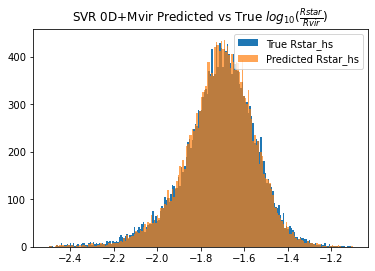

In [22]:
plt.hist(df_0D_log.SubhaloRstar_hs_log, bins=200, label='True Rstar_hs'
        , range=(-2.50, 0-1.1))
plt.hist(y_pred_SVR_all.loc[:, 'y_pred_SVR SIM 0D'], bins=200, alpha=0.7, label='Predicted Rstar_hs'
        , range=(-2.5, -1.1))
plt.legend(loc='upper right')
plt.title(r'SVR 0D+Mvir Predicted vs True $log_{10}(\frac{Rstar}{Rvir})$')
# plt.savefig('TNG-SIM_images/v20_SVR_0D/v20_Histogram_SVR_pred_true_TNG-SIM_0D_AllDatasetwMvir.jpeg', dpi=500)
plt.show()

In [30]:
best_SVR_trainscore_all

0.9115005103387199

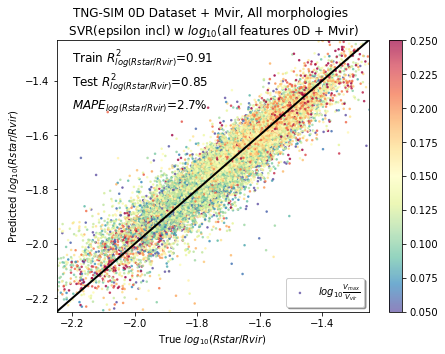

In [38]:
# Plot of Predicted log10 Rstar/Rvir vs True log 10 Rstar/Rvir

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_0D_log.SubhaloRstar_hs_log, y_pred_SVR_all,
            c = df_0D_log.SubhaloVmax_hs_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}\frac{V_{max}}{V_{vir}}$', vmin=0.05, vmax=0.25)
ax.text(-2.2, -1.5, r'Train $R^{2}_{log(Rstar/Rvir)}$=0.91' + '\n' + r'Test $R^{2}_{log(Rstar/Rvir)}$=0.85' + '\n' + r'$MAPE_{log(Rstar/Rvir)}$=2.7$\%$ ', size=12)
ax.axis([-2.25,-1.25, -2.25,-1.25])
ax.plot([-3.0, -1.0], [-3.0, -1.0], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM 0D Dataset + Mvir, All morphologies \n ' + r'SVR(epsilon incl) w $log_{10}$(all features 0D + Mvir) ')
ax.set_xlabel(r'True $log_{10}(Rstar/Rvir)$')
ax.set_ylabel(r'Predicted $log_{10}(Rstar/Rvir)$')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v20_SVR_0D/v20_TNG-SIM_0D_AllDatasetwMvir_SVRwepsilon_size_pred_colorlogVmaxVvir_1.jpeg', dpi=500)
plt.show()

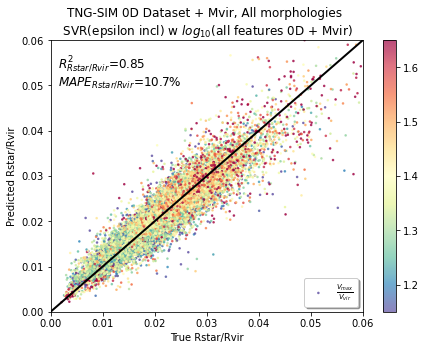

In [50]:
# Plot of Predicted Rstar/Rvir vs Rstar/Rvir 

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(10**(df_0D_log.SubhaloRstar_hs_log), 10**(y_pred_SVR_all),
            c = df_0D.SubhaloVmax_hs, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$\frac{V_{max}}{V_{vir}}$', vmin=1.15, vmax=1.65)
ax.text(0.0015, 0.05, r'$R^{2}_{Rstar/Rvir}$=0.85' + '\n' + r'$MAPE_{Rstar/Rvir}$=10.7$\%$ ', size=12)
ax.axis([0.0,0.06, 0.0,0.06])
ax.plot([-3.0, 1.0], [-3.0, 1.0], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM 0D Dataset + Mvir, All morphologies \n ' + r'SVR(epsilon incl) w $log_{10}$(all features 0D + Mvir) ')
ax.set_xlabel(r'True Rstar/Rvir')
ax.set_ylabel(r'Predicted Rstar/Rvir')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v20_SVR_0D/v20_TNG-SIM_0D_AllDataset_SVRwepsilon_size_pred_colorlogVmaxVvir_2.jpeg', dpi=500)
plt.show()

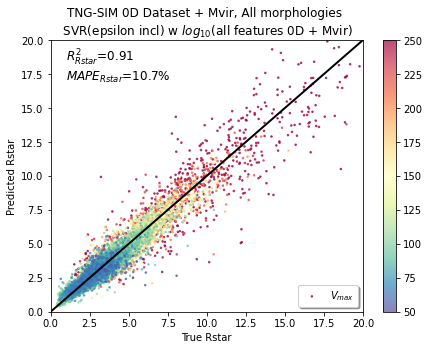

In [51]:
# Plot of Predicted Raw Rstar vs Raw Rstar 

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw.SubhaloRstar, (10**(y_pred_SVR_all.loc[:, 'y_pred_SVR SIM 0D']))*df_raw.Group_R_TopHat200,
            c = df_raw.SubhaloVmax, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$V_{max}$', vmin=50, vmax=250)
ax.text(1.0, 17, r'$R^{2}_{Rstar}$=0.91' + '\n' + r'$MAPE_{Rstar}$=10.7$\%$ ', size=12)
ax.axis([0.0,20, 0.0,20])
ax.plot([-3.0, 30], [-3.0, 30], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM 0D Dataset + Mvir, All morphologies \n ' + r'SVR(epsilon incl) w $log_{10}$(all features 0D + Mvir) ')
ax.set_xlabel(r'True Rstar')
ax.set_ylabel(r'Predicted Rstar')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v20_SVR_0D/v20_TNG-SIM_0D_AllDataset_SVRwepsilon_size_pred_colorlogVmaxVvir_3.jpeg', dpi=500)
plt.show()

### Other metrics

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

##### <font color='darkgreen'> <a id =10> </a> <br>log(Rstar/Rvir) metrics

In [33]:
r2_score(df_0D_log.loc[:, 'SubhaloRstar_hs_log'], y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D'])

0.8629371971650472

In [34]:
mean_squared_error(df_0D_log.loc[:, 'SubhaloRstar_hs_log'], y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D'])

0.003997877666330775

In [35]:
np.sqrt(mean_squared_error(df_0D_log.loc[:, 'SubhaloRstar_hs_log'], y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D']))

0.06322877245630168

In [36]:
mean_absolute_error(df_0D_log.loc[:, 'SubhaloRstar_hs_log'], y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D'])

0.045962563899445495

In [37]:
# MAPE in log scale
mean_absolute_percentage_error(df_0D_log.loc[:, 'SubhaloRstar_hs_log'], y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D'])

0.026703869983071133

##### <font color='darkgreen'> <a id =10> </a> <br>Rstar/Rvir metrics

In [40]:
r2_score(df_0D.loc[:, 'SubhaloRstar_hs'], 10**(y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D']))

0.8484617850281531

In [41]:
mean_squared_error(df_0D.loc[:, 'SubhaloRstar_hs'], 10**(y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D']))

9.307782773319478e-06

In [42]:
np.sqrt(mean_squared_error(df_0D.loc[:, 'SubhaloRstar_hs'], 10**(y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D'])))

0.003050865905496254

In [43]:
# MAPE in original variables
mean_absolute_percentage_error(10**(df_0D_log.loc[:, 'SubhaloRstar_hs_log']), 10**(y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D']))

0.10731514632772586

##### <font color='darkgreen'> <a id =10> </a> <br> Rstar metrics

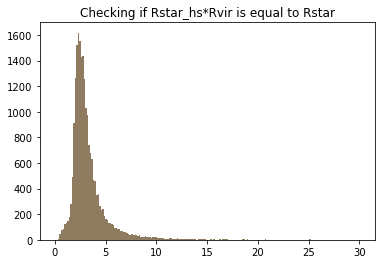

In [44]:
plt.hist(df_raw.loc[:, 'SubhaloRstar'], bins=200, range=(0,30))
plt.hist(df_0D.loc[:, 'SubhaloRstar_hs']*df_raw.Group_R_TopHat200, bins=200, range=(0,30), alpha=0.5)
plt.title('Checking if Rstar_hs*Rvir is equal to Rstar')

plt.show()

In [45]:
r2_score(df_raw.loc[:, 'SubhaloRstar'], 10**(y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D'])*df_raw.Group_R_TopHat200)

0.9111072115243373

In [46]:
mean_squared_error(df_raw.loc[:, 'SubhaloRstar'], 10**(y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D'])*df_raw.Group_R_TopHat200)

0.6658419597179422

In [47]:
np.sqrt(mean_squared_error(df_raw.loc[:, 'SubhaloRstar'], 10**(y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D'])*df_raw.Group_R_TopHat200))

0.8159913968406421

In [48]:
mean_absolute_percentage_error(df_raw.loc[:, 'SubhaloRstar'], 10**(y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D'])*df_raw.Group_R_TopHat200)

0.10731528602662023

### <font color='purple'> <a id =3> </a> <br> SVR Learning Curve

In [10]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'r2', scale = False):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    
    fig, ax = plt.subplots(figsize=(7, 5))
#     plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("# of training examples",fontsize = 14)
 
    ax.set_ylabel(r"$R^{2}$ score",fontsize = 14)
    
    if (scale == True):
        scaler = sklearn.preprocessing.StandardScaler()
        X = scaler.fit_transform(X)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score from CV")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score from CV")

    ax.legend(loc="best",fontsize = 12)
    return fig

Elapsed time to run SVR Learning Curves on the complete dataset: 34.079 seconds


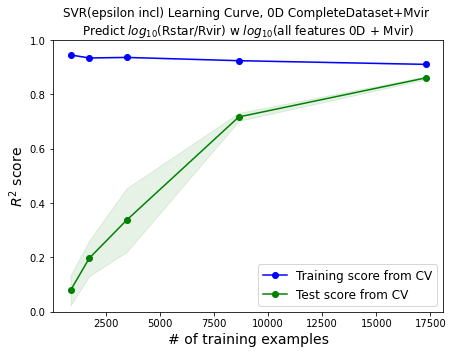

In [53]:
# this code takes ~2.5min to run on the whole dataset with ~22,000 galaxies
start_time = time.time()

lc_all = plot_learning_curve(best_SVR_all, 'SVR(epsilon incl) Learning Curve, 0D CompleteDataset+Mvir \n'+r'Predict $log_{10}$(Rstar/Rvir) w $log_{10}$(all features 0D + Mvir)', X_all, y_all, ylim=(0.0, 1.0), train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
# plt.savefig('LC_SVR_Complete_Dataset.jpeg', dpi=500)
elapsed_time = time.time() - start_time

print(f"Elapsed time to run SVR Learning Curves on the complete dataset: {elapsed_time:.3f} seconds")

In [54]:
# lc_all.savefig('TNG-SIM_images/v20_SVR_0D/v20_TNG-SIM_0D_AllDataset_SVRwepsilon_Learning_Curve_2.jpeg', dpi=500)

### <font color='darkred'> <a id =3> </a> <br> Conclusion: Including Mvir in the 0D dataset AND optimizing epsilon, as well as the other parameters of SVR, increases the performance of the SVR to R2=0.91. For comparison, SVR using only 0D dataset AND optimizing epsilon performs with R2=0.89. 
    
    Note 1: Adding epsilon as a parameter to optimize has led to a better performing SVR model. Without optimizing for SVR, I got R2=0.88 for both 0D only and 0D+Mvir datasets. 
    
    Note 2: For comparison, I get R2=0.85 for RandomForests w 0D only dataset, and R2=0.86 for RandomForests w 0D+Mvir dataset. Therefore, the increase in performance due to the addition of Mvir is mostly present in SVR, and less in RF.

### <font color='darkred'> <a id =3> </a> <br> Conclusion 2: Using the TransformedTargetRegressor to normalize the target as well for SVR runs does not work with GridSearchCV. I get the following error: 'TransformedTargetRegressor' object is not iterable. Therefore, if I want to use it, I have to use Optuna package to optimize the hyperparameters. At this point, it is more important to run the ML models in the disk-only subset of galaxies. Hence, I will not run optuna optimization, but will move on with using SVR and normalized features only.

### <font color='purple'> <a id =10> </a> <br> Complete 0D+Mvir: SVR Feature Ranking

In [10]:
def run_svr_search_pipeline(X, y):
    
    
    piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

    piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

    parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale', 0.01, 1.0, 10, 100], 
              'svr__C':[0.1, 1.0, 10.0, 100.0, 1000], \
              'svr__epsilon':[0.05,0.1,0.2], 
                 }


    model_all = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True, random_state=2024), \
                     verbose = 0, n_jobs = -1, return_train_score=True)

    model_all.fit(X, y)
    
    scores_lim = pd.DataFrame(model_all.cv_results_)

    scores_lim = scores_lim[['params','mean_test_score','std_test_score','mean_train_score', 'mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)
    
    return scores_lim
#     return scores_lim['mean_test_score']

def calculate_r_score( X , y ,column_names):
    x_new = X[list(column_names)]
    # print(column_names)
    r_square = run_svr_search_pipeline(x_new, y)['mean_test_score']
    
    return r_square.max()


def print_results(max_col_names, max_col_rscores):
    k= 1
    for i, j in zip(max_col_names, max_col_rscores):
        print("\t", k, i,j)
        k +=1
        
def calc_ith_iteration( X, y, max_col_names, max_col_rscores, orj_column_names, i):
    r_score_dict = {}
    for column_names in tqdm(orj_column_names): # orj_column_names = original column names
        # count += 1
        # print(count, max_col_names , column_names)
        feature_list = max_col_names + [column_names]
        r_score = calculate_r_score(X , y ,feature_list)
        r_score_dict[column_names] = r_score
    
    max_col_names.append(max(r_score_dict, key=r_score_dict.get))
    max_col_rscores.append(max(r_score_dict.values()))
    # print("asdfasd", max_col_names[len(max_col_names) - 1])
    
    orj_column_names.remove(max_col_names[len(max_col_names) - 1])
    
    return max_col_names, max_col_rscores, orj_column_names, r_score_dict

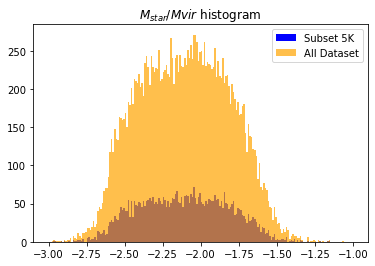

In [13]:
# choose a subsample of 5K galaxies since the original dataset is too large
df_0D_sample = df_0D_log.sample(n = 5000, random_state = 2023)

plt.hist(df_0D_sample.SubhaloMstar_hs_log, 
         color='blue', label='Subset 5K', bins=200, range=(-3.0,-1.0))
plt.hist(df_0D_log.SubhaloMstar_hs_log,  color='orange', 
         label='All Dataset', alpha=0.7, bins=200, range=(-3.0,-1.0))
plt.title(r'${M_{star}}/Mvir$ histogram ')
plt.legend()
# plt.savefig('TNG-SIM_images/v20_SVR_0D/v20_MstarMvir_histogram_5K_21K.jpeg', dpi=500)
plt.show()

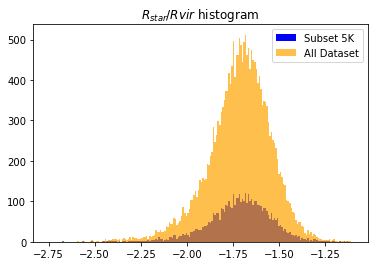

In [16]:
# choose a subsample of 5K galaxies since the original dataset is too large
# df_0D_sample = df_0D_log.sample(n = 5000, random_state = 2023)

plt.hist(df_0D_sample.SubhaloRstar_hs_log, 
         color='blue', label='Subset 5K', bins=200, range=(-2.75,-1.1))
plt.hist(df_0D_log.SubhaloRstar_hs_log,  color='orange', 
         label='All Dataset', alpha=0.7, bins=200, range=(-2.75,-1.1))
plt.title(r'${R_{star}}/Rvir$ histogram ')
plt.legend()
# plt.savefig('TNG-SIM_images/v20_SVR_0D/v20_RstarRvir_histogram_5K_21K.jpeg', dpi=500)
plt.show()

In [17]:
X_all = df_0D_sample.drop(columns=['SubhaloRstar_hs_log'])
 

y_all = df_0D_sample.loc[:,'SubhaloRstar_hs_log']

  6%|██▌                                      | 1/16 [08:15<2:03:47, 495.18s/it]

	 1 SubhaloVmaxRad_hs_log 0.3078147600888657



 12%|█████                                   | 2/16 [55:46<7:18:54, 1881.07s/it]

	 1 SubhaloVmaxRad_hs_log 0.3078147600888657
	 2 SubhaloMH2_hs_log 0.4955123319168074



 19%|███████▏                              | 3/16 [1:47:52<8:50:44, 2449.58s/it]

	 1 SubhaloVmaxRad_hs_log 0.3078147600888657
	 2 SubhaloMH2_hs_log 0.4955123319168074
	 3 SubhaloStarMetallicity_log 0.5847325527497041



 25%|█████████▌                            | 4/16 [2:24:22<7:49:26, 2347.21s/it]

	 1 SubhaloVmaxRad_hs_log 0.3078147600888657
	 2 SubhaloMH2_hs_log 0.4955123319168074
	 3 SubhaloStarMetallicity_log 0.5847325527497041
	 4 SubhaloMstar_hs_log 0.7115393108197582



 31%|███████████▉                          | 5/16 [2:56:48<6:43:48, 2202.59s/it]

	 1 SubhaloVmaxRad_hs_log 0.3078147600888657
	 2 SubhaloMH2_hs_log 0.4955123319168074
	 3 SubhaloStarMetallicity_log 0.5847325527497041
	 4 SubhaloMstar_hs_log 0.7115393108197582
	 5 Group_M_TopHat200_log 0.7933021654446595



 38%|██████████████▎                       | 6/16 [3:19:11<5:18:20, 1910.05s/it]

	 1 SubhaloVmaxRad_hs_log 0.3078147600888657
	 2 SubhaloMH2_hs_log 0.4955123319168074
	 3 SubhaloStarMetallicity_log 0.5847325527497041
	 4 SubhaloMstar_hs_log 0.7115393108197582
	 5 Group_M_TopHat200_log 0.7933021654446595
	 6 SubhaloSFRinRad_log 0.8141155565155778



 44%|████████████████▋                     | 7/16 [3:34:00<3:56:27, 1576.43s/it]

	 1 SubhaloVmaxRad_hs_log 0.3078147600888657
	 2 SubhaloMH2_hs_log 0.4955123319168074
	 3 SubhaloStarMetallicity_log 0.5847325527497041
	 4 SubhaloMstar_hs_log 0.7115393108197582
	 5 Group_M_TopHat200_log 0.7933021654446595
	 6 SubhaloSFRinRad_log 0.8141155565155778
	 7 SubhaloGasMetallicity_log 0.8289939424276879



 50%|███████████████████                   | 8/16 [3:44:43<2:50:33, 1279.15s/it]

	 1 SubhaloVmaxRad_hs_log 0.3078147600888657
	 2 SubhaloMH2_hs_log 0.4955123319168074
	 3 SubhaloStarMetallicity_log 0.5847325527497041
	 4 SubhaloMstar_hs_log 0.7115393108197582
	 5 Group_M_TopHat200_log 0.7933021654446595
	 6 SubhaloSFRinRad_log 0.8141155565155778
	 7 SubhaloGasMetallicity_log 0.8289939424276879
	 8 SubhaloMgas_hs_log 0.8374518242504486



 56%|█████████████████████▍                | 9/16 [3:53:06<2:00:55, 1036.45s/it]

	 1 SubhaloVmaxRad_hs_log 0.3078147600888657
	 2 SubhaloMH2_hs_log 0.4955123319168074
	 3 SubhaloStarMetallicity_log 0.5847325527497041
	 4 SubhaloMstar_hs_log 0.7115393108197582
	 5 Group_M_TopHat200_log 0.7933021654446595
	 6 SubhaloSFRinRad_log 0.8141155565155778
	 7 SubhaloGasMetallicity_log 0.8289939424276879
	 8 SubhaloMgas_hs_log 0.8374518242504486
	 9 SubhaloBHMass_hs_log 0.8448299044499191



 56%|█████████████████████▍                | 9/16 [3:59:37<3:06:22, 1597.46s/it]

	 1 SubhaloVmaxRad_hs_log 0.3078147600888657
	 2 SubhaloMH2_hs_log 0.4955123319168074
	 3 SubhaloStarMetallicity_log 0.5847325527497041
	 4 SubhaloMstar_hs_log 0.7115393108197582
	 5 Group_M_TopHat200_log 0.7933021654446595
	 6 SubhaloSFRinRad_log 0.8141155565155778
	 7 SubhaloGasMetallicity_log 0.8289939424276879
	 8 SubhaloMgas_hs_log 0.8374518242504486
	 9 SubhaloBHMass_hs_log 0.8448299044499191
	 10 SubhaloRgas_hs_log 0.8458300724610531


Text(0, 0.5, '$R^{2}$ score')

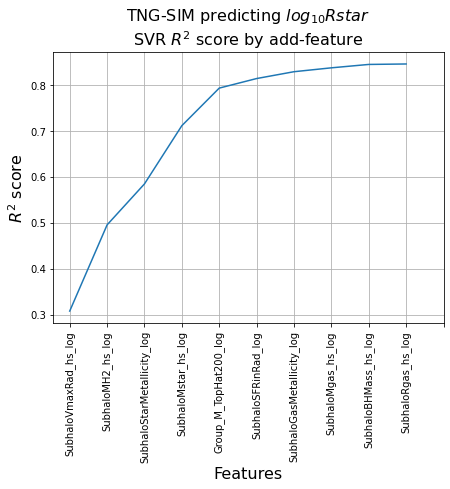

In [18]:
X = X_all
y = y_all

# Add-feature Ranking Method
# Note: This step calls 4 funcitons: run_random_search_pipeline(X,y), calculate_r_score(column_names),
# print_results(max_col_names, max_col_rscores), calc_ith_iteration(max_col_names, max_col_rscores, orj_column_names, i)

column_names = X.columns


max_col_names = [] # 
max_col_rscores = []
orj_column_names = list(column_names)


# first loop - over all features  
for i in tqdm(range(1, len(orj_column_names)+1)):
#     max_col_names, max_col_rscores, orj_column_names, r_score_dict = calc_ith_iteration(X, y, max_col_names, max_col_rscores, orj_column_names, i)
    
    
    # second loop, using i selected features + each of the remaining features individually
    r_score_dict = {} # to store r_squares from second loop
    
    for column_name in tqdm(orj_column_names,miniters = 6,colour = 'red', leave = None): 
        
        feature_list = max_col_names + [column_name]

        r_square = run_svr_search_pipeline(X[feature_list], y)
        r_score_dict[column_name] = r_square['mean_test_score'].max()
    
    max_col_names.append(max(r_score_dict, key=r_score_dict.get))
    max_col_rscores.append(max(r_score_dict.values()))

    
    orj_column_names.remove(max_col_names[len(max_col_names) - 1])
    
    print_results(max_col_names, max_col_rscores)
    
    if i==10: break # stop at 10th most important feature as I have observed that usually after the 7th feature R2 stabilizes

df_max_r_scores = pd.DataFrame({
    'feature_number' : range(1,11),
    'features':max_col_names,
    'r_sq_score': max_col_rscores  })
# Save the important feature ranking obtained by add-column method
#df_max_r_scores.to_csv('Max r scores by add column method.csv', index=False)

fig_add_feature=df_max_r_scores.plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                    legend=False, grid=True, 
                    xticks=range(0,11))
fig_add_feature.set_title(label= r'TNG-SIM predicting $log_{10}Rstar$' + '\n' + 'SVR $R^{2}$ score by add-feature',fontsize=16)
fig_add_feature.set_xlabel('Features',fontsize=16)
fig_add_feature.set_ylabel(r'$R^{2}$ score',fontsize=16)

In [20]:
# fig_add_feature.get_figure().savefig('TNG-SIM_images/v20_SVR_0D/v20_TNG-SIM_0DwMvir_AllDataset_SVR_R_score_by_add_feature.jpg', dpi=500)

# df_max_r_scores.to_csv('TNG-SIM_images/v20_SVR_0D/v20_TNG-SIM_0DwMvir_AllDataset_SVR_Max r scores by add column method.csv', index=False)


Most important features from 0D+Mvir SVR:

	 1 SubhaloVmaxRad_hs_log 0.3078147600888657
	 2 SubhaloMH2_hs_log 0.4955123319168074
	 3 SubhaloStarMetallicity_log 0.5847325527497041
	 4 SubhaloMstar_hs_log 0.7115393108197582
	 5 Group_M_TopHat200_log 0.7933021654446595
	 6 SubhaloSFRinRad_log 0.8141155565155778
	 7 SubhaloGasMetallicity_log 0.8289939424276879
	 8 SubhaloMgas_hs_log 0.8374518242504486
	 9 SubhaloBHMass_hs_log 0.8448299044499191
	 10 SubhaloRgas_hs_log 0.8458300724610531

### <font color='purple'> <a id =10> </a> <br> Complete 0D Dataset + Mvir w DM features only: SVR

In [11]:
X_dm = df_0D_log.drop(columns=['SubhaloRstar_hs_log', 
                                'SubhaloBHMass_hs_log',
                                 'SubhaloBHMdot_hs_log',
                                 'SubhaloGasMetallicity_log',
                                 'SubhaloSFRinRad_log',
                                 'SubhaloStarMetallicity_log',
                                 'SubhaloVelDisp_hs_log',
                                 'SubhaloVmax_hs_log',
                                 'SubhaloVmaxRad_hs_log',
                                 'SubhaloRgas_hs_log',
                                 'SubhaloRstar_hs_log',
                                 'SubhaloMgas_hs_log',
                                 'SubhaloMstar_hs_log',
                             'SubhaloMHI_hs_log',
                             'SubhaloMH2_hs_log',]) # drop target and all galaxy properties

y_dm = df_0D_log.loc[:,'SubhaloRstar_hs_log']

In [12]:
# this code takes ~ ...min to run it on the complete TNG-SIM dataset with ~22,000 galaxies 

start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the regressor
print(piped_model.get_params())
#optimizing SVR

parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale', 0.01, 1.0, 10, 100], 
              'svr__C':[0.1, 1.0, 10.0, 100.0, 1000], \
              'svr__epsilon':[0.05,0.1,0.2],
              }


model_dm = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

model_dm.fit(X_dm, y_dm)

print('Best params, best score:', "{:.4f}".format(model_dm.best_score_), \
      model_dm.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR results on TNG-SIM 0D+Mvir Complete Dataset w DM features: {elapsed_time:.3f} seconds")

{'memory': None, 'steps': [('standardscaler', StandardScaler()), ('svr', SVR())], 'verbose': False, 'standardscaler': StandardScaler(), 'svr': SVR(), 'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'svr__C': 1.0, 'svr__cache_size': 200, 'svr__coef0': 0.0, 'svr__degree': 3, 'svr__epsilon': 0.1, 'svr__gamma': 'scale', 'svr__kernel': 'rbf', 'svr__max_iter': -1, 'svr__shrinking': True, 'svr__tol': 0.001, 'svr__verbose': False}
Fitting 3 folds for each of 75 candidates, totalling 225 fits


/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params, best score: 0.1980 {'svr__C': 0.1, 'svr__epsilon': 0.1, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR results on TNG-SIM 0D+Mvir Complete Dataset w DM features: 6419.953 seconds


In [13]:
start_time = time.time()

best_SVR_dm=model_dm.best_estimator_

best_SVR_trainscore_dm=model_dm.cv_results_['mean_train_score'][model_dm.best_index_]

scores_SVR_dm = cross_val_score(best_SVR_dm, X_dm, y_dm, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute this patch of code: {elapsed_time:.3f} seconds")

# It took 72 seconds to run this patch of code

start_time = time.time()

y_pred_SVR_dm = cross_val_predict(best_SVR_dm, X_dm, y_dm, cv = KFold(n_splits=5, shuffle=True, random_state=10))

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR y_pred with cv=5 and optimal model from above, on 0D+Mvir Complete Dataset w DM features: {elapsed_time:.3f} seconds")

# It took 71 seconds to run this patch of code

Elapsed time to compute this patch of code: 15.656 seconds
Elapsed time to compute the SVR y_pred with cv=5 and optimal model from above, on 0D+Mvir Complete Dataset w DM features: 15.685 seconds


In [14]:
y_pred_SVR_df_dm = pd.DataFrame({'y_pred_SVR SIM 0D': y_pred_SVR_dm})

# y_pred_SVR_df_dm.to_csv('TNG-SIM_images/v20_SVR_0D/v20_TNG-SIM_0D_wDMfeatures_AllDatasetwMvir_y_pred_SVRwepsilon_predicted_sizes_2.csv', index=False)

y_pred_SVR_dm = pd.read_csv('TNG-SIM_images/v20_SVR_0D/v20_TNG-SIM_0D_wDMfeatures_AllDatasetwMvir_y_pred_SVRwepsilon_predicted_sizes_2.csv')

print('trainscore', best_SVR_trainscore_dm)

trainscore 0.2049999135775513


Elapsed time to run SVR Learning Curves on the 0D+Mvir complete dataset w DM features: 13.732 seconds


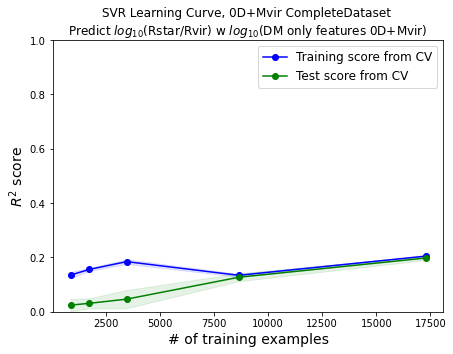

In [15]:
# this code takes ~2.5min to run on the whole dataset with ~22,000 galaxies
start_time = time.time()

lc_dm = plot_learning_curve(best_SVR_dm, 'SVR Learning Curve, 0D+Mvir CompleteDataset \n'+r'Predict $log_{10}$(Rstar/Rvir) w $log_{10}$(DM only features 0D+Mvir)', X_dm, y_dm, ylim=(0.0, 1.0), train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
elapsed_time = time.time() - start_time

print(f"Elapsed time to run SVR Learning Curves on the 0D+Mvir complete dataset w DM features: {elapsed_time:.3f} seconds")

# lc_dm.savefig('TNG-SIM_images/v20_SVR_0D/v20_TNG-SIM_0D_wDMfeatures_AllDataset_SVR_Learning_Curve_2.jpeg', dpi=500)

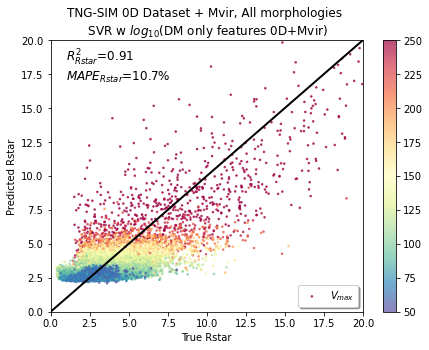

In [18]:
# Plot of Predicted Raw Rstar vs Raw Rstar 

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw.SubhaloRstar, (10**(y_pred_SVR_dm.loc[:, 'y_pred_SVR SIM 0D']))*df_raw.Group_R_TopHat200,
            c = df_raw.SubhaloVmax, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$V_{max}$', vmin=50, vmax=250)
ax.text(1.0, 17, r'$R^{2}_{Rstar}$=0.91' + '\n' + r'$MAPE_{Rstar}$=10.7$\%$ ', size=12)
ax.axis([0.0,20, 0.0,20])
ax.plot([-3.0, 30], [-3.0, 30], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM 0D Dataset + Mvir, All morphologies \n ' + r'SVR w $log_{10}$(DM only features 0D+Mvir) ')
ax.set_xlabel(r'True Rstar')
ax.set_ylabel(r'Predicted Rstar')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v20_SVR_0D/v20_TNG-SIM_0D_wDMfeatures_AllDataset_SVR_size_pred_colorlogVmaxVvir_3.jpeg', dpi=500)
plt.show()